In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import corner
import jax.numpy as jnp
from opt_einsum import contract
from jax.config import config
import jax
config.update("jax_enable_x64", True)

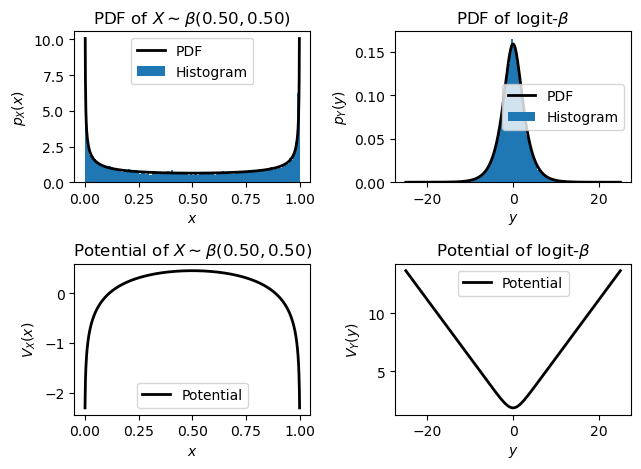

In [2]:
""" 
References
----------

(1) https://stats.stackexchange.com/questions/286042/derivation-of-the-mean-and-variance-of-the-logit-transform-of-a-beta-random-vari

"""

# Define a beta distributed random variable
alpha = 0.5
beta = 0.5
rv = scipy.stats.beta(alpha, beta)
beta_samples = rv.rvs(size=10000)

# Definitions needed for transformation
B = scipy.special.beta(alpha, beta) # Normalization constant
logit = lambda x: np.log(x / (1 - x))
logistic_CDF = lambda x: 1 / (1 + np.exp(-x))
logistic_PDF = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2
logit_beta_pdf = lambda x: (1/B) * logistic_CDF(x) ** alpha * (1 - logistic_CDF(x)) ** beta
logit_beta_samples = logit(beta_samples)

# Plot the PDF of the beta rv and its histogram
fig, ax = plt.subplots(2,2)
x = np.linspace(0, 1, 1000)
beta_pdf_values = rv.pdf(x)
ax[0, 0].plot(x, beta_pdf_values, 'k-', lw=2, label='PDF')
ax[0, 0].hist(beta_samples, density=True, bins=100, label='Histogram')
ax[0, 0].set_xlabel(r'$x$')
ax[0, 0].set_ylabel(r'$p_X(x)$')
ax[0, 0].set_title(r'PDF of $X \sim \beta(%.2f, %.2f)$' % (alpha, beta))
ax[0, 0].legend()

# Plot the potential of the beta rv
beta_potential_values = -np.log(beta_pdf_values)
ax[1, 0].plot(x, beta_potential_values, 'k-', lw=2, label='Potential')
ax[1, 0].set_xlabel(r'$x$')
ax[1, 0].set_ylabel(r'$V_X(x)$')
ax[1, 0].set_title(r'Potential of $X \sim \beta(%.2f, %.2f)$' % (alpha, beta))
ax[1, 0].legend()

# Plot the PDF of the logit(beta) rv and its histogram
y = np.linspace(-25, 25, 1000);
logit_beta_pdf_values = logit_beta_pdf(y)
ax[0, 1].plot(y, logit_beta_pdf_values, 'k-', lw=2, label='PDF');
ax[0, 1].hist(logit_beta_samples, density=True, bins=100, label='Histogram');
ax[0, 1].set_title(r'PDF of logit-$\beta$')
ax[0, 1].set_xlabel(r'$y$')
ax[0, 1].set_ylabel(r'$p_Y(y)$')
ax[0, 1].legend()

# Plot the potential of the PDF
ax[1, 1].set_xlabel(r'$y$')
ax[1, 1].set_ylabel(r'$V_Y(y)$')
ax[1, 1].set_title(r'Potential of logit-$\beta$')
logit_beta_potential_values = -np.log(logit_beta_pdf(y))
ax[1, 1].plot(y, logit_beta_potential_values, 'k-', lw=2, label='Potential')
ax[1, 1].legend()

plt.tight_layout()

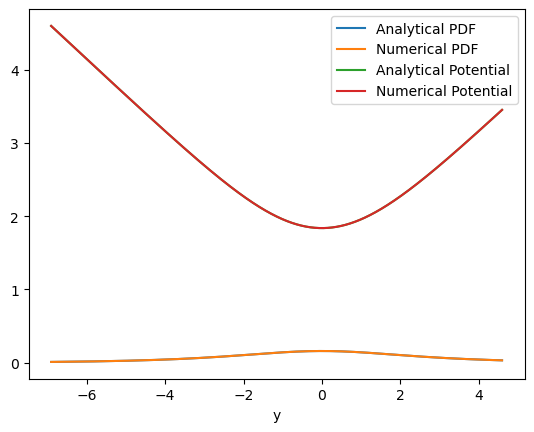

In [11]:
# Bounded space
alpha = 0.5
beta = 0.5
rv = scipy.stats.beta(alpha, beta)
x = np.linspace(0.001, 0.99, 1000) # Avoid drawing points too close to the boundary for numerical stability
y = logit(x) # Transform grid into unbounded space

# Unbounded space 
fig4, ax4 = plt.subplots()
ax4.plot(y, logit_beta_pdf(y), label='Analytical PDF') # I believe that the transformation preserves mass!
ax4.plot(y, rv.pdf(x) * logistic_PDF(y), label='Numerical PDF') 

ax4.plot(y, -np.log(logit_beta_pdf(y)), label='Analytical Potential')
ax4.plot(y, -np.log(rv.pdf(x) * logistic_PDF(y)), label='Numerical Potential')
ax4.set_xlabel('y')
ax4.legend()

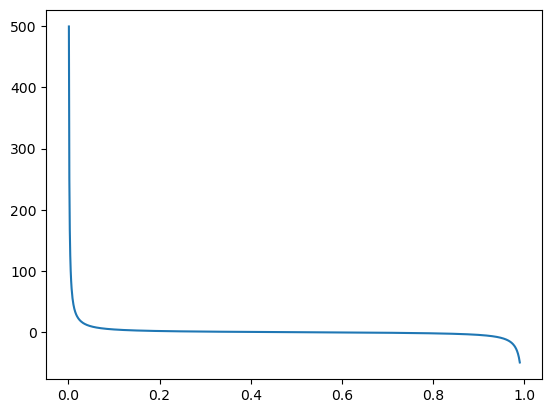

In [9]:
# Gradients of potential in bounded space
V_X = lambda y: -jax.scipy.stats.beta.logpdf(y, alpha, beta)
g_V_X = jax.grad(V_X)
plt.plot(x, jax.vmap(g_V_X)(x))



In [5]:
g_v_sharp(y).shape

(1000, 1000)